# Random Processes and Monte Carlo Methods

Problem Set 3 explores some physics processes that require the use of random numbers. Today we will briefly introduce random numbers and a class of algorithms known as Monte Carlo methods. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch

## Random numbers

Many applications call for the use of random numbers. In physics, some processes are described probabilistically but fundamentally random, e.g., radioactive decay. Classical (non-quantum) phenomena are not truly random, but are often described only statistically and best treated as random, e.g., Brownian motion. So we need a way of generating "random" numbers. What are often called "random numbers" in most programming applications are actually **pseudorandom numbers**, which are generated deterministically, by starting with some "seed" value and then applying some algorithm to come up with a number that seems random. Let's code up our own extremely simple version of a pseudorandom number generator. 

### Linear congruential random number generator

Consider this equation:

$$x' = (ax + c)~\mathrm{mod}~m$$

Where $a$, $c$, and $m$ are integer constants and $x$ is an integer variable. When you feed this program an integer $x$, it spits out another integer $x'$, which is then fed back in as $x$ to produce a new $x'$, and so forth. This process will produce a sequence of seemingly random numbers. 

&#128309; Code it up yourself, starting from the suggested constants below, and compute and store 100 values starting from the "seed" value of 1. 

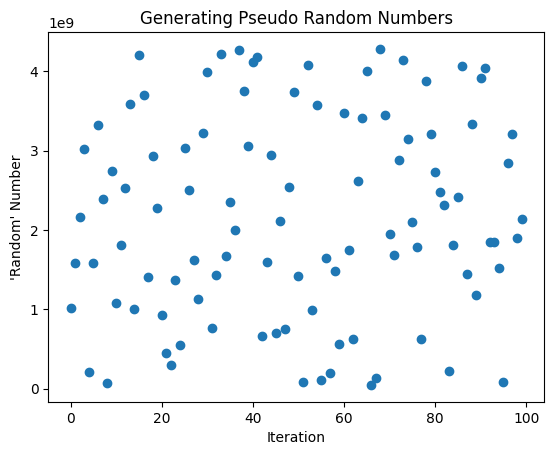

In [3]:
a = 1664525
c = 1013904223
m = 2**32
seed = 1

# initialize relevant variables
random_nums, x = [], seed

# update x and x prime 100 times
for _ in range(100):
    x = (a*x + c) % m
    random_nums.append(x)

# plot pseudo random numbers
plt.scatter(np.arange(0, 100), random_nums)
plt.xlabel("Iteration")
plt.ylabel("'Random' Number")
plt.title('Generating Pseudo Random Numbers')
plt.show()

&#128310; Comment on your plot. Do the values appear random? Are they genuinely, truly random? 

✍🏽 The values appearly generally random. There isn't any clear distribution to the numbers and it seems relatively uniform across our graph. We could measure this by running this multiple times (different seeds), and then seeing if the distributions look similar in different tries.

&#128309; By which of your constants would you need to divide your output to put all of your random numbers on the range $[0, 1)$? Try it. 

✍🏽 We would need to divide output by m, the mod value, in order to get our numbers into the specified range. This is because our random numbers can at max be the mod value and at minimum will be 0. 

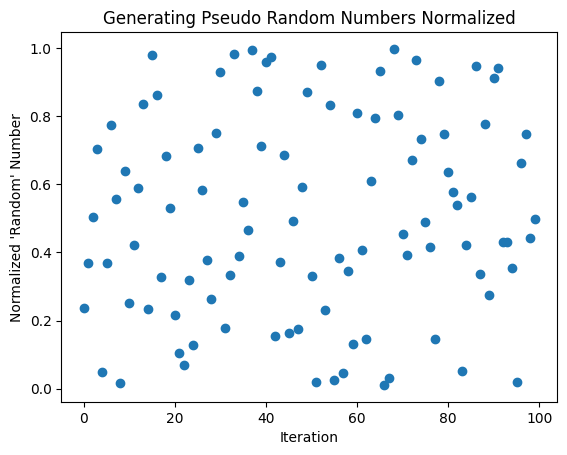

In [4]:
random_nums = [num/m for num in random_nums]

# plot pseudo random numbers
plt.scatter(np.arange(0, 100), random_nums)
plt.xlabel("Iteration")
plt.ylabel("Normalized 'Random' Number")
plt.title('Generating Pseudo Random Numbers Normalized')
plt.show()

From here on out, we will use existing implementations of pseudorandom number generators that are much better than this one. Instead of pointing you to specific functions, take a look through the <a target="_blank" rel="noopener noreferrer"  href="https://docs.python.org/3/library/random.html#">numpy random module</a>. 

&#128310; Pick out two functions that look useful and describe here what each does and what you might use it for. 

✍🏽

random.randrange seems useful as we can generate a random integer in a particular range. We might use this to rotate a qubit by a random amount, or to randomly initialize our shooting method optimization.

random.choice also might be useful because we can choose from a list we can predefine. We might use this to randomly choose an activity to do in a day or to randomly choose a guess from a list. 

### Rock, Paper, Scissors

&#128309; Practice using functions from the numpy `random` module by writing a function that will randomly return "rock", "paper", or "scissors". 

In [5]:
import random

action = random.choice(["rock", "paper", "scissors"])
print("I play: ", action)

I play:  scissors


&#128310; Use your function to play a game of rock, paper, scissors, either against your function or against a classmate's function. Play best of five and report the results here. 

✍🏽 I won 3 games and lost 2 games. 

| My Move    | Random Move | Winner |
| -------- | ------- | ------- |
| Rock  | Scissors   | Me! |
| Paper | Scissors    | Bot |
| Scissors    | Rock    | Bot |
| Rock  | Scissors    | Me! |
| Paper | Rock     | Me! |



## Monte Carlo Integration 

Suppose we need to evaluate the integral 

$$I = \int_0^2 \sin^2 \left[\frac{1}{x(2-x)}\right] dx$$

&#128309; Plot the integrand on $(0, 2)$ and behold its pathological nature. 

/var/folders/9r/sw7rn4810sjddctl8q8nlcy80000gn/T/ipykernel_57357/3454066738.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  return np.sin((x*(2-x))**-1)**2
/var/folders/9r/sw7rn4810sjddctl8q8nlcy80000gn/T/ipykernel_57357/3454066738.py:2: RuntimeWarning: invalid value encountered in sin
  return np.sin((x*(2-x))**-1)**2


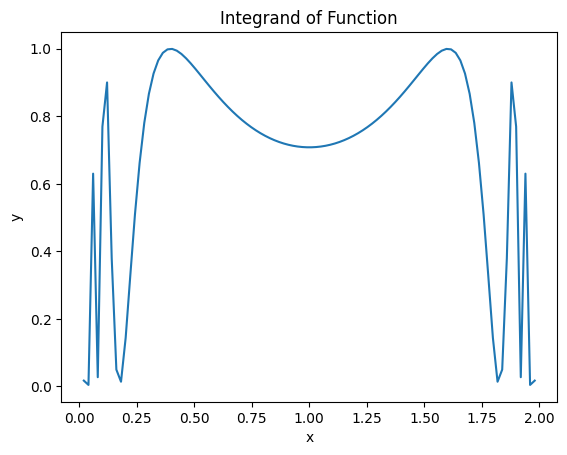

In [6]:
def func(x):
    return np.sin((x*(2-x))**-1)**2

x = np.linspace(0, 2, 100)

# plot 
plt.plot(x, func(x))
plt.title("Integrand of Function")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

&#128310; Early in this course we discussed numerical integration. How well do you think an algorithm like the trapezoidal rule is going to perform on this? Why?

✍🏽 Given the large slopes on both ends of this graph, an algorithm like trapezoidal rule probably won't work very well at all. If we take two evenly distributed steps, the chance they accurately capture the shape of the graph even with a decently narrow step size is very low.

Another approach is **Monte Carlo integration**, which simply says: let's approximate the area under the curve by generating random numbers within some bounding area and asking if each is over or under the curve. In the limit of many samples, the *fraction* of points below the curve should approximately equal the integral. 

More specifically, let's say that for this example we are going to generate random numbers in the rectangle defined by an x-value between (0, 2) and a y-value between (0, 1). The area of this rectangle is $A = 2$, so if we sample uniformly at random in this rectangle, the probability that a point falls below our curve is $p = I/A$, where $I$ is the integral we want to approximate. We are going to approximate the probability $p$ by the fraction of $N$ points that fall below the curve: $p \approx k/N$. So our approximation of the integral is

$$I \approx \frac{kA}{N}$$

&#128310; Check your understanding: what is $k$? 

✍🏽 $k$ is the number of points that fall under the specified curve. We know this because we are dividing $k$ by the total number of points $N$ and getting a unitless probabilty, hence it must be a measure of the number of points.

&#128309; Use Monte Carlo integration to evaluate our pathological integral above. 

In [7]:
# define params/vars
N = 10000
x_min, x_max = 0, 2
y_min, y_max = 0, 1
k = 0

# calculate total area
A = (x_max - x_min) * (y_max - y_min)

for _ in range(N): # iterate N times
    x = random.uniform(x_min, x_max)
    if random.uniform(y_min, y_max) < func(x):
        k += 1 # increment k if greater than function

print("I = ", (k*A/N))

I =  1.448


### Optional: connection to Physics 130

&#128310; Those of you in Physics 130 this quarter might recall a discussion of <a target="_blank" rel="noopener noreferrer" href="https://stanford.edu/class/physics130/coin/">Schrödinger's coin.</a> Describe in a few sentences how you would code up the quantum coin. 

✍🏽 Not in Physics 130 : /

## Monte Carlo Simulation

A **Monte Carlo simulation** is a simulation that uses random numbers to simulate some physical process in order to estimate something about that process. Monte Carlo simulations are widely used in many applications you will come across, including in statistical mechanics, to estimate propagated error, and many classes of problems where one needs to sample a high-dimensional parameter space. In Problem Set 3 you are exploring a **Markov Chain Monte Carlo (MCMC)** method in some depth. Feel free to read through that problem first, if you haven't already -- or work through today's notebook but revisit it after tackling Problem Set 3 to appreciate more of the background behind Monte Carlo simulations and Markov chains. 

Today we will step you through an application of a Monte Carlo simulation to a **global optimization** problem, using a method known as **simulated annealing**. We have studied optimization problems already in this class -- recall our exploration of root-finding -- but the methods we explored were suitable for finding *local* minima or maxima, and did not guarantee that the solution was the global minimum or maximum. Often we need to solve a global optimization problem -- e.g., if we want to find the ground state energy of a quantum system, we are looking for the overall minimum of the energy. Global optimization is a difficult task computationally! 

### Simulated annealing

Glassworkers, metalworkers, etc. are familiar with the fact that rapidly cooling hot materials like glass or metal causes defects that weaken the materials. This happens because the system gets trapped in a local minimum of the energy -- just as a Monte Carlo simulation could get trapped in an energy minimum. "Annealing" is the process of slowly cooling materials so that they end up strong. Simulated annealing is an approach to global optimization that mimics this physical process by using a Monte Carlo simulation with a temperature parameter that is gradually lowered from some initially high value toward zero. One can prove that if the cooling is slow enough, this will converge to the ground state, i.e., the global minimum, though of course as usual we will need to find a compromise between "slow enough" and having our program run in a reasonable amount of time. 

Simulated annealing is perhaps most famous as a method for solving the *traveling salesman problem*, an optimization problem in which a salesperson starts at home and needs to find the shortest path that visits a set number of cities exactly once before returning home. 


## The dimer covering problem

A dimer is a two-atom polymer. Often in condensed matter physics one wants to place dimers on the surface of some solid that defines a grid. No two dimers can overlap. The question is how many dimers can fit on the lattice (this is going to be obvious for the problem below but it is not always obvious in practice)! 

Use simulated annealing to solve the dimer problem on an L x L lattice. The "energy" function for this system is the negative of the number of dimers, such that this energy is minimized when there is a maximum number of dimers. Read more about this in Problem Set 3, Problem 4. The moves for the Markov chain are the following:

1. Choose two adjacent sites on the lattice at random.
2. If those two sites are currently both empty, place a dimer on them.
3. If the two sites are currently occupied by a single dimer, remove the dimer from the lattice with the probability $e^{-1/T}$. (Here we are just giving you this probability, but read through Problem Set 3 and convince yourself that this is correct.)
4. Otherwise, do nothing. 

&#128309; Implement and visualize this using the comments and starter code below. 

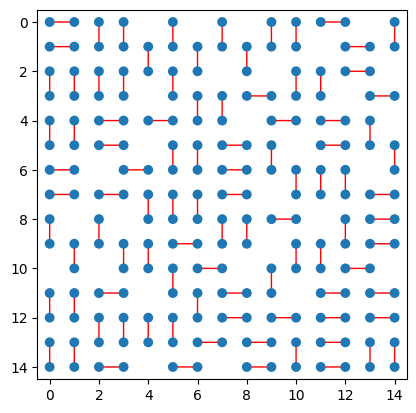

In [8]:
# Initialize the lattice: use (capital) L for the length of the lattice. Start with L = 15
L = 15

# Create an L x L array of integer zeros called (lowercase) s to store an index representing each dimer. 
s = np.zeros((L, L))

# We will use capital T for the temperature. Start with Tmax = 5.0 and Tmin = 1E-2.
Tmax = 5.0
Tmin = 1E-2

# Initialize tau to 1E4
tau = 1E3

# We will use dimer_indx to keep track of the dimers. Start with dimer_indx = 0
dimer_indx = 0

# Let's also count the dimers. Start with n_dimers = 0
n_dimers = 0

# This is for drawing the dimers
radius = 0.2
all_sites1 = {}
all_sites2 = {}
all_connectors = {}

dimer_grid = np.zeros((L, L))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(dimer_grid, cmap='binary')

# Set our original temperature (capital) T to (capital) Tmax
T = Tmax

# We will use lowercase t for the time. Set the time t to 0.
t = 0

# We will use a while loop to simulate the annealing process. 
# We will continue the loop while temperature (uppercase) T is greater than Tmin.
while (T > Tmin): 

    # Cooling: increment (lowercase) t by 1 and set (uppercase) T to Tmax * exp(-t/tau), where the t in the exponential is lowercase.
    t += 1
    T = Tmax * np.exp(-t/tau)
    
    # Use a random number to decide whether to try to add a vertical dimer or a horizontal dimer
    if random.choice([True, False]):
        # If we're adding a vertical dimer, pick an x index of the lattice at random, and assign it to (lowercase) i1 and i2, 
        # the indices of both ends of the dimer. 
        x_index = np.random.randint(0, L)
        i1 = x_index
        i2 = x_index

        # Pick a random y index, j1, and set j2 to be the next y index (j1 + 1)
        y_index = np.random.randint(0, L-1)
        j1 = y_index
        j2 = y_index + 1
    
    # Perform the same steps as above, but for a horizontal dimer
    else:
        # y index of dimer
        y_index = np.random.randint(0, L)
        j1 = y_index
        j2 = y_index

        # x index of dimer
        x_index = np.random.randint(0, L-1)
        i1 = x_index
        i2 = x_index + 1
        

    # Check whether s[i1, j1] is equal to s[i2, j2]
    if s[i1, j1] == s[i2, j2]:

        # If both sites in the grid are 0, we will add a dimer here. Increment dimer_indx and set them equal to a new dimer
        if s[i1, j1] == 0 and s[i2, j2] == 0:
            # Increment (add one to) dimer_indx, which we are using to index each dimer we add.
            dimer_indx += 1

            # Set the value of s at these indices to dimer_indx
            s[i1, j1] = dimer_indx
            s[i2, j2] = dimer_indx

            # Increment (add one to) n_dimers, our count of the total dimers, since we just added one
            n_dimers += 1

            # The following is one way of plotting these dimers
            all_sites1[dimer_indx] = Circle((i1, j1), radius=radius)
            all_sites2[dimer_indx] = Circle((i2, j2), radius=radius)
            all_connectors[dimer_indx] = ConnectionPatch((i1, j1), (i2, j2), 'data', 'data', arrowstyle='-', color="red")

        # If the sites are not equal, we will try to remove a dimer. 
        # Find a random number between 0 and 1. If it is less than exp(-1/T), remove the dimer. Otherwise nothing happens.
        elif np.random.uniform(0, 1) < np.exp(-1/T):
            # Find the dimer index of the dimer to remove
            dimer_to_remove = s[i1, j1]

            # Set s at both of the dimer indices to 0
            s[i1, j1] = 0
            s[i2, j2] = 0

            # Decrement (remove one from) n_dimers, since we just removed one
            n_dimers -= 1
            
            # Remove the dimer from the plot
            all_sites1.pop(dimer_to_remove)
            all_sites2.pop(dimer_to_remove)
            all_connectors.pop(dimer_to_remove)

# Plot your dimers
[ax.add_patch(all_connectors[d]) for d in all_connectors.keys()];
[ax.add_patch(all_sites1[d]) for d in all_sites1.keys()];
[ax.add_patch(all_sites2[d]) for d in all_sites2.keys()];

&#128310; Increase and decrease `tau` by an order of magnitude or more and rerun your code. Which way (increasing or decreasing) makes your code run faster? Which way gives you better solutions? 

✍🏽 When I increase my value for `tau`, I get a better solution but it takes considerably longer. As I decrease my value for `tau`, the solution converges quicker but gives me a less accurate solution. I tested 1E3, 1E4, and 1E5 to determine this behavior. 

&#128309; *(Optional:)* For added fun, see if you can animate the process of placing your dimers on the lattice. 

# Acknowledgments

S.E. Clark, with problems adapted from Newman 2013